In [1]:
import torch
import torch.nn as nn
# from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/boot/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: HIP initialization: Unexpected error from hipGetDeviceCount(). Did you run some cuda functions before calling NumHipDevices() that might have already set an error? Error 101: hipErrorInvalidDevice (Triggered internally at ../c10/hip/HIPFunctions.cpp:110.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
# hyperparameters
input_size = 28 * 28
hidden_size = 100
num_of_classes = 10   # MNIST digits
num_epochs = 2
batch_size = 32
learning_rate = 0.001

In [7]:
# MNIST
train_dataset = torchvision.datasets.MNIST(root="./data/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root="./data/", train=False, transform=transforms.ToTensor(), download=False)

# Dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


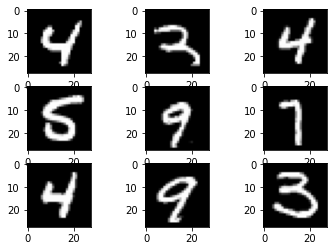

In [26]:
%matplotlib inline
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
plt.show()

In [27]:
# Design model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self,).__init__()
        
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.activation = nn.LeakyReLU()
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=num_classes)
        # self.softmax # the loss function CrossEntropyLoss (will take care of this problem)
        
    def forward(self, x):
        out = torch.nn.functional.leaky_relu(self.layer1(x))
        return self.layer2(out)


model = NeuralNet(input_size=input_size, hidden_size=hidden_size, num_classes=num_of_classes)

In [30]:
# 2) loss and optimizer
loss = nn.CrossEntropyLoss()   # applies Softmax for us!
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [34]:
# 3) training loop
total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, label) in enumerate(train_loader):
        # reshaping and putting the images to the device (gpu) if available
        images = torch.reshape(images, (-1, 28*28)).to(device)
        labels = labels.to(device)
        # forward pass
        outputs = model(images)
        # calculate loss
        L = loss(outputs, labels)
        # backpropagation
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        
        if not (i+1)%100:
            print(f"Epoch {epoch}/{num_epochs}: step {i+1}/{total_steps}: loss: {L.item():.5f}")


Epoch 0/2: step 100/1875: loss: 2.07127
Epoch 0/2: step 200/1875: loss: 2.09655
Epoch 0/2: step 300/1875: loss: 2.06341
Epoch 0/2: step 400/1875: loss: 2.02267
Epoch 0/2: step 500/1875: loss: 2.07488
Epoch 0/2: step 600/1875: loss: 2.04592
Epoch 0/2: step 700/1875: loss: 2.05983
Epoch 0/2: step 800/1875: loss: 2.08697
Epoch 0/2: step 900/1875: loss: 2.05789
Epoch 0/2: step 1000/1875: loss: 2.03272
Epoch 0/2: step 1100/1875: loss: 2.05634
Epoch 0/2: step 1200/1875: loss: 2.02987
Epoch 0/2: step 1300/1875: loss: 2.07418
Epoch 0/2: step 1400/1875: loss: 2.06045
Epoch 0/2: step 1500/1875: loss: 2.04576
Epoch 0/2: step 1600/1875: loss: 2.03179
Epoch 0/2: step 1700/1875: loss: 2.06226
Epoch 0/2: step 1800/1875: loss: 2.04562
Epoch 1/2: step 100/1875: loss: 2.05318
Epoch 1/2: step 200/1875: loss: 2.04853
Epoch 1/2: step 300/1875: loss: 2.04435
Epoch 1/2: step 400/1875: loss: 2.04639
Epoch 1/2: step 500/1875: loss: 2.03842
Epoch 1/2: step 600/1875: loss: 2.04236
Epoch 1/2: step 700/1875: loss:

In [ ]:
# evaluating the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # value, index
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()

        